<a href="https://colab.research.google.com/github/javmencia/RelativeBelief/blob/BiasCalculations/RegressionModelwithvectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.special import gammaln
from scipy import stats
import time
import math

def normal_logp_np(x, mu, sigma):
    return -0.5 * ((x - mu) / sigma) ** 2 - np.log(sigma) - 0.5 * np.log(2 * np.pi)

In [ ]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
sigma0 = 1
mu0 = np.dot(X, beta0)

# Generate response variable y
y = np.dot(X, beta0) + np.random.normal(0, sigma0, n)
print("y", y)

def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_ = pm.MvNormal('y_', mu=mu, cov= (sigma0**2)*np.eye(n), shape = n)

    # Prior log-probability
    prior_pd = pm.Deterministic("prior_pd", pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2)*np.eye(n), shape=(n,)), mu).sum())

    # Posterior mean and covariance for beta
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    print(cov_beta_post)
    mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, y)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))
    print(mean_beta_post)

    # Posterior log-probability
    posterior_beta = pm.MvNormal('posterior_beta', mu=mean_beta_post, cov=cov_beta_post)
    posterior_pd = pm.Deterministic("posterior_pd", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_beta), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu).sum())

    # Log BR
    logRB_prior_pd = pm.Deterministic("logRB_prior_pd", posterior_pd - prior_pd)

    # Likelihood
    likelihood_prior_pd = pm.Deterministic("likelihood_prior_pd", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma0**2)*np.eye(n), shape=n), y_).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

y [ 2.02285181  3.72778458 -0.090022    0.80840662 -0.8493315   4.81056796
 -3.30669514 -0.59163993 -2.15400519 -1.01798558 -1.9658222  -3.54945497
  2.09785444  1.25024263 -1.13535921 -0.4309976   0.52444264  4.91380017
  2.14464964 -1.80711183]
[[ 0.06352878 -0.02965681]
 [-0.02965681  0.07935113]]
[1.09114098 1.74170568]


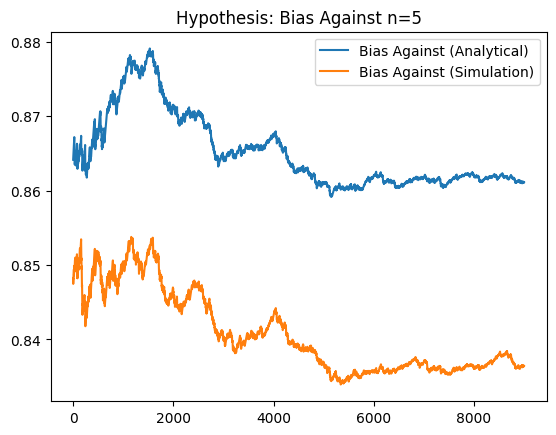

In [ ]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

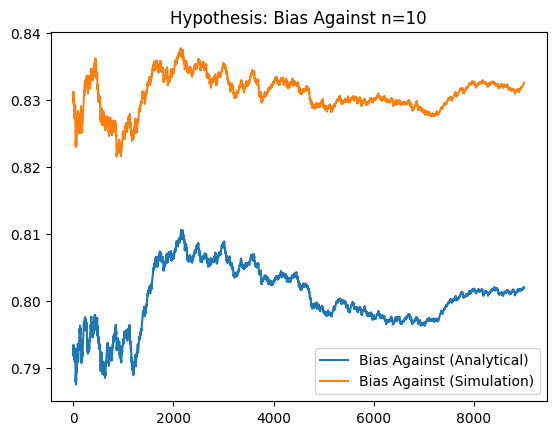

In [ ]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

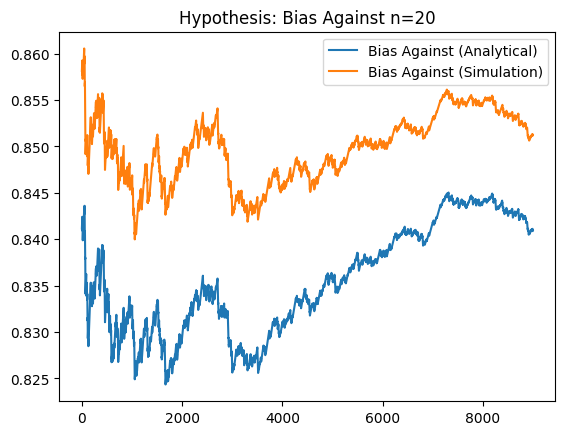

In [ ]:
# Calculate the bias against the prior hypothesis
bias_against = idata.posterior["logRB_prior_pd"].values.ravel() <= 0
t = bias_against.shape[0]
burn = 1000
bias_against_mci = bias_against.cumsum() / np.arange(1, t+1)

# Extract posterior samples for simulation
beta_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
x_samples = idata.posterior['y_'].values  # Shape (chains, draws, n)

# Compute log likelihoods for all samples at once
marginal_likelihoods = normal_logp_np(x_samples[:, :, :, np.newaxis], beta_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd = idata.posterior['likelihood_prior_pd'].values.ravel()

bias_against_ml = (likelihood_prior_pd - log_marginal_likelihoods) <= 0

bias_against_ml_mci = bias_against_ml.cumsum() / np.arange(1, len(bias_against_ml) + 1)

plt.plot(bias_against_mci[burn:], label='Bias Against (Analytical)')
plt.plot(bias_against_ml_mci[burn:], label='Bias Against (Simulation)')
plt.title("Hypothesis: Bias Against n={}".format(n))
plt.legend()
plt.show()

Bias In Favor

Regular Upper Lower (Same delta for both)

In [8]:
import numpy as np
import pymc as pm
import arviz as az

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
delta = 0.05
sigma0 = 1
betal = beta0 - delta
print(betal)
betau = beta0 + delta
print(betau)

mu0 = np.dot(X, beta0)
mul = np.dot(X, betal)
muu = np.dot(X, betau)

# Generate response variable y
yl = mul + np.random.normal(0, sigma0, n)
yu = muu + np.random.normal(0, sigma0, n)


def normal_logp(x, mu, sigma):
    return -0.5 * np.log(2 * np.pi * sigma**2) - 0.5 * ((x - mu)**2 / sigma**2)

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    # Likelihood
    mu = pm.Deterministic("mu", pm.math.dot(X, beta))
    y_l = pm.MvNormal('y_l', mu=mul, cov= (sigma0**2)*np.eye(n), shape = n)
    y_u = pm.MvNormal('y_u', mu=muu, cov= (sigma0**2)*np.eye(n), shape = n)

    # Prior log-probability
    prior_pd = pm.Deterministic("prior_pd", pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2)*np.eye(n), shape=(n,)), mu).sum())

    # Posterior mean and covariance for beta
    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
    print(cov_beta_post)
    mean_beta_postl = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))
    mean_beta_postu = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yu)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))

    # Posterior log-probability
    posterior_betal = pm.MvNormal('posterior_betal', mu=mean_beta_postl, cov=cov_beta_post)
    posterior_betau = pm.MvNormal('posterior_betau', mu=mean_beta_postu, cov=cov_beta_post)

    posterior_pdl = pm.Deterministic("posterior_pdl", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betal), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu0).sum())
    posterior_pdu = pm.Deterministic("posterior_pdu", pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betau), cov=(sigma0**2)*np.eye(n), shape=(n, )), mu0).sum())

    # Log BR
    logBR_prior_pdl = pm.Deterministic("logBR_prior_pdl", posterior_pdl - prior_pd)
    logBR_prior_pdu = pm.Deterministic("logBR_prior_pdu", posterior_pdu - prior_pd)

    # Likelihood
    likelihood_prior_pdl = pm.Deterministic("likelihood_prior_pdl", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2)*np.eye(n), shape=n), y_l).sum())
    likelihood_prior_pdu = pm.Deterministic("likelihood_prior_pdu", pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2)*np.eye(n), shape=n), y_u).sum())

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

[0.95 1.95]
[1.05 2.05]
[[0.0438812  0.00333695]
 [0.00333695 0.02683799]]


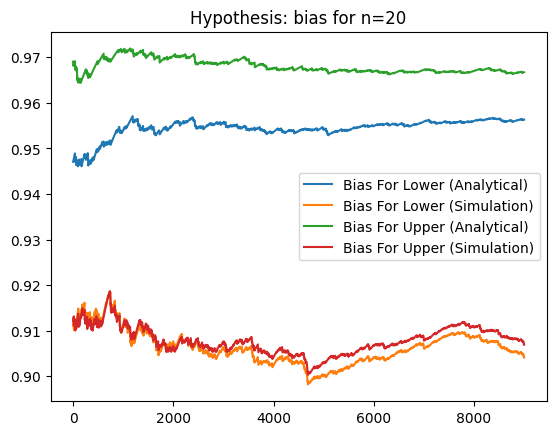

In [9]:
bias_forlower = idata.posterior['logBR_prior_pdl'].values.ravel() > 0
bias_forupper = idata.posterior['logBR_prior_pdu'].values.ravel() > 0
tl = bias_forlower.shape[0]
tu = bias_forupper.shape[0]
burn = 1000
bias_for_mcilower = bias_forlower.cumsum()/np.arange(1,tl+1)
bias_for_mciupper = bias_forupper.cumsum()/np.arange(1,tu+1)


use = 1000  # Number of samples to use

# Extract posterior samples
mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]  # Use 1000 samples
xl_samples = idata.posterior['y_l'].values  # Shape (chains, draws, n)
xu_samples = idata.posterior['y_u'].values  # Shape (chains, draws, n)


# Compute log likelihoods for all samples at once
marginal_likelihoods_lower = normal_logp_np(xl_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
marginal_likelihoods_upper = normal_logp_np(xu_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)

# Average the likelihoods over the samples
log_marginal_likelihoods_lower = np.log(np.exp(marginal_likelihoods_lower).mean(axis=-1)).ravel()
log_marginal_likelihoods_upper = np.log(np.exp(marginal_likelihoods_upper).mean(axis=-1)).ravel()

# Compute biases
likelihood_prior_pd_lower = idata.posterior['likelihood_prior_pdl'].values.ravel()
likelihood_prior_pd_upper = idata.posterior['likelihood_prior_pdu'].values.ravel()

bias_for_ml_lower = (likelihood_prior_pd_lower - log_marginal_likelihoods_lower) >= 0
bias_for_ml_upper = (likelihood_prior_pd_upper - log_marginal_likelihoods_upper) >= 0

bias_for_ml_mci_lower = bias_for_ml_lower.cumsum() / np.arange(1, len(bias_for_ml_lower) + 1)
bias_for_ml_mci_upper = bias_for_ml_upper.cumsum() / np.arange(1, len(bias_for_ml_upper) + 1)

plt.plot(bias_for_mcilower[burn:], label='Bias For Lower (Analytical)')
plt.plot(bias_for_ml_mci_lower[burn:], label='Bias For Lower (Simulation)')
plt.plot(bias_for_mciupper[burn:], label='Bias For Upper (Analytical)')
plt.plot(bias_for_ml_mci_upper[burn:], label='Bias For Upper (Simulation)')
plt.title("Hypothesis: bias for n={}".format(n))
plt.legend()


Delta values around the circle:

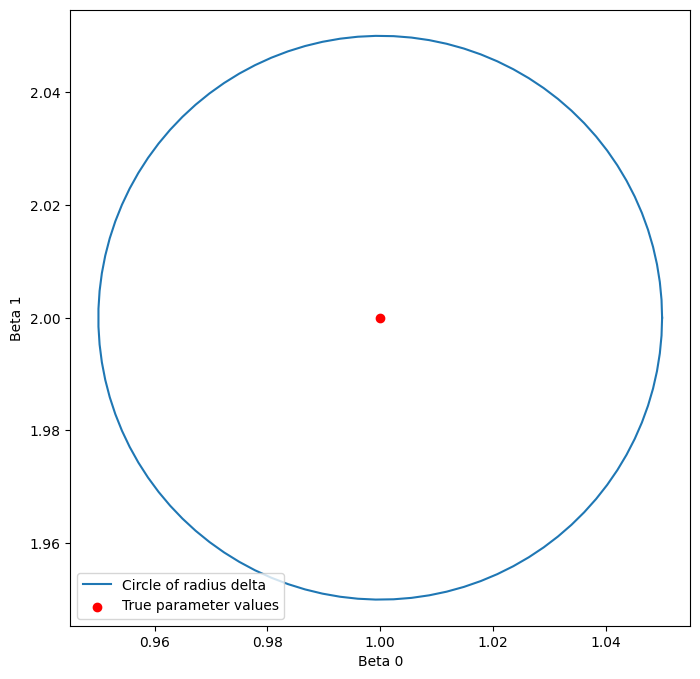

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# True parameter values
beta0 = np.array([1, 2])
delta = 0.05  # Radius of the circle

# Generate points on the circle
num_points = 100  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
x = beta0[0] + delta * np.cos(theta)
y = beta0[1] + delta * np.sin(theta)

# Plotting the circle and the true parameter values
plt.figure(figsize=(8, 8))
plt.plot(x, y, label='Circle of radius delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')
plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc = 3)
plt.axis('equal')
plt.show()

# Print the points on the circle
circle_points = np.column_stack((x, y))


/usr/local/lib/python3.10/dist-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (23), generating only 20 plots
  warnings.warn(


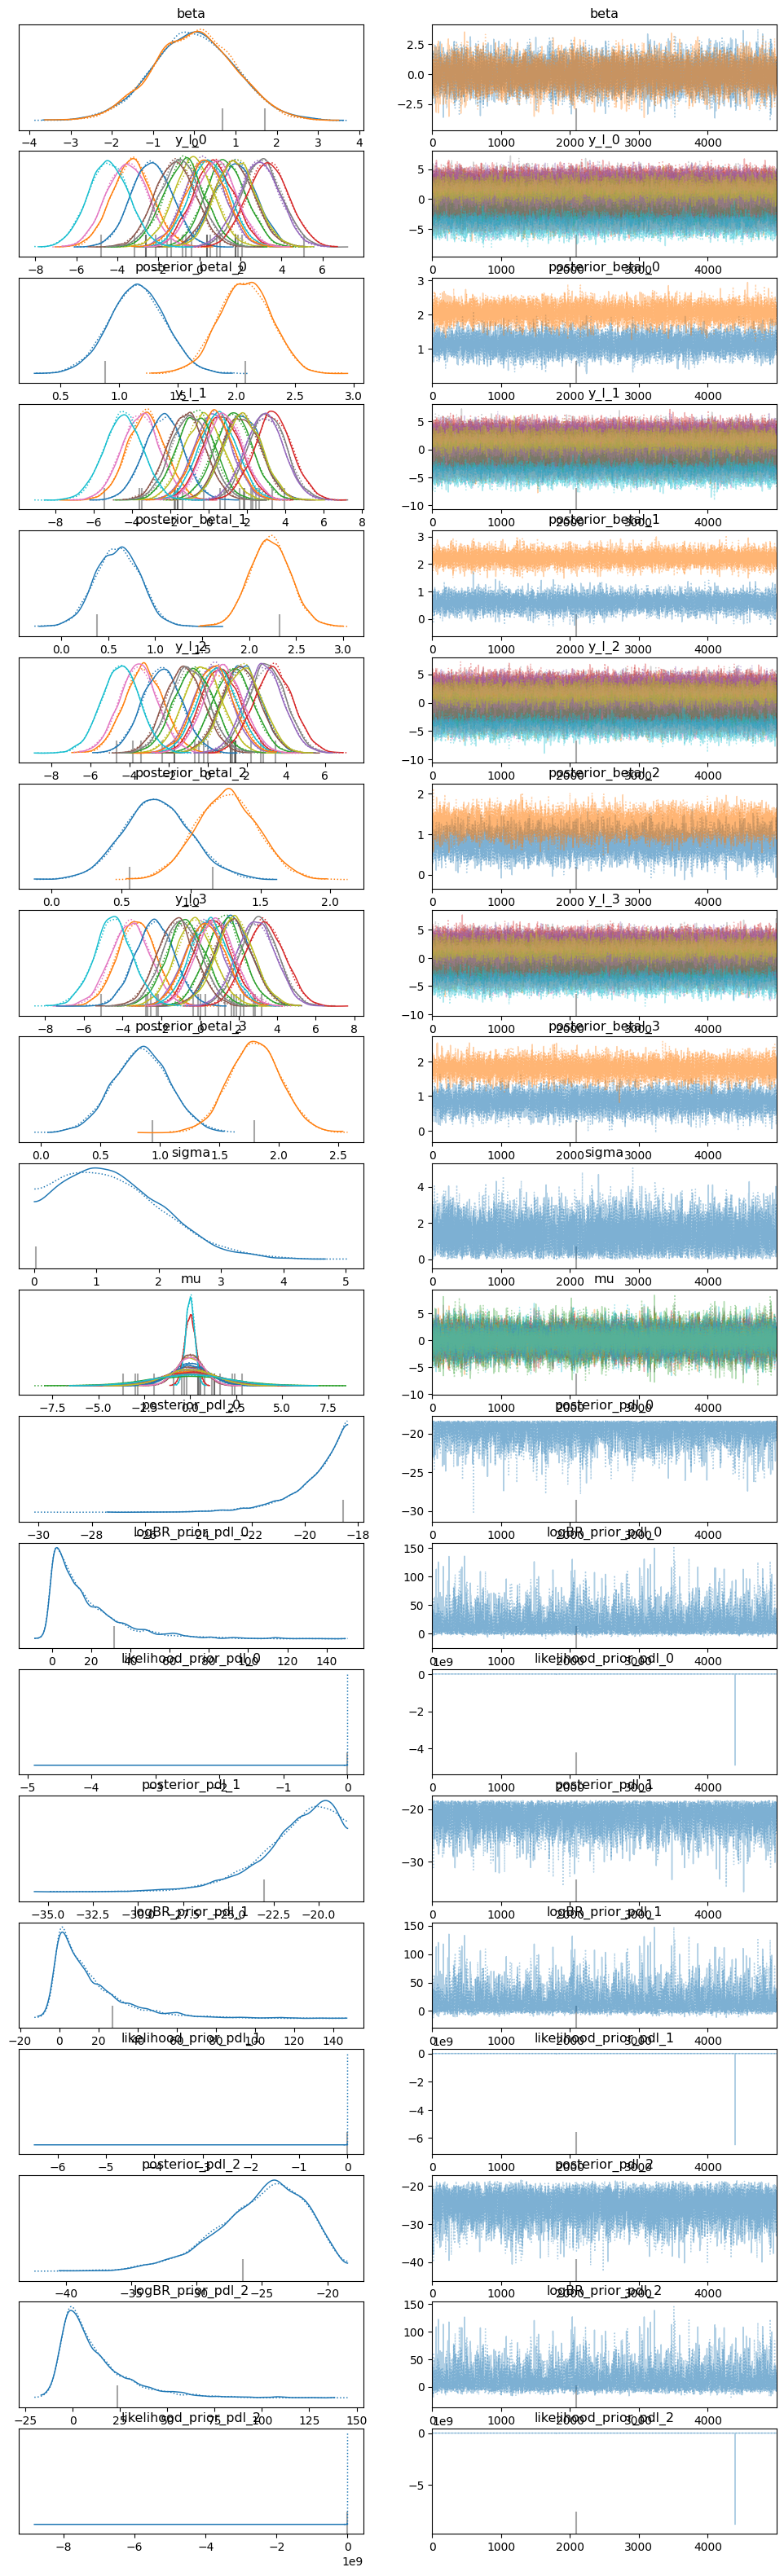

<xarray.Dataset>
Dimensions:                  (chain: 2, draw: 5000, beta_dim_0: 2,
                              y_l_0_dim_0: 20, posterior_betal_0_dim_0: 2,
                              y_l_1_dim_0: 20, posterior_betal_1_dim_0: 2,
                              y_l_2_dim_0: 20, posterior_betal_2_dim_0: 2,
                              y_l_3_dim_0: 20, posterior_betal_3_dim_0: 2,
                              mu_dim_0: 20)
Coordinates:
  * chain                    (chain) int64 0 1
  * draw                     (draw) int64 0 1 2 3 4 ... 4995 4996 4997 4998 4999
  * beta_dim_0               (beta_dim_0) int64 0 1
  * y_l_0_dim_0              (y_l_0_dim_0) int64 0 1 2 3 4 5 ... 15 16 17 18 19
  * posterior_betal_0_dim_0  (posterior_betal_0_dim_0) int64 0 1
  * y_l_1_dim_0              (y_l_1_dim_0) int64 0 1 2 3 4 5 ... 15 16 17 18 19
  * posterior_betal_1_dim_0  (posterior_betal_1_dim_0) int64 0 1
  * y_l_2_dim_0              (y_l_2_dim_0) int64 0 1 2 3 4 5 ... 15 16 17 18 19
  * poste

In [31]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1
# Generate points on the circle
num_points = 100  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

posterior_pds = []
logBR_prior_pds = []
likelihood_prior_pds = []


with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    X_transpose = X.T
    Sigma_inv = np.eye(n) / sigma0**2
    Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

    # Iterate over each point on the circle
    for i, betal in enumerate(circle_points[:4]):
        # Calculate mu for each point on the circle
        mul = np.dot(X, betal)

        # Generate response variable y for each point on the circle
        yl = mul + np.random.normal(0, sigma0, n)

        # Likelihood
        y_l = pm.MvNormal(f'y_l_{i}', mu=mul, cov=(sigma0**2) * np.eye(n), shape=n)

        # Posterior mean and covariance for beta
        cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
        mean_beta_post = np.dot(cov_beta_post, np.dot(X_transpose, np.dot(Sigma_inv, yl)) + Sigma_beta_inv.dot(np.ones(p) * mu_prior_mean))

        # Posterior log-probability
        posterior_betal = pm.MvNormal(f'posterior_betal_{i}', mu=mean_beta_post, cov=cov_beta_post)
        posterior_pdl = pm.Deterministic(f'posterior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betal), cov=(sigma0**2) * np.eye(n), shape=(n,)), mu0).sum())
        posterior_pds.append(posterior_pdl)

        # Log BR
        logBR_prior_pdl = pm.Deterministic(f'logBR_prior_pdl_{i}', posterior_pdl - pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2) * np.eye(n), shape=(n,)), pm.math.dot(X, beta)).sum())
        logBR_prior_pds.append(logBR_prior_pdl)

        # Likelihood
        likelihood_prior_pdl = pm.Deterministic(f'likelihood_prior_pdl_{i}', pm.logp(pm.MvNormal.dist(mu=mu0, cov=(sigma**2) * np.eye(n), shape=n), y_l).sum())
        likelihood_prior_pds.append(likelihood_prior_pdl)

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

# Use ArviZ to analyze the results
az.summary(idata)
az.plot_trace(idata)
plt.show()
print(idata.posterior)

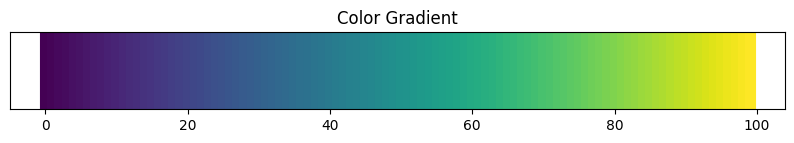

IndexError: list index out of range

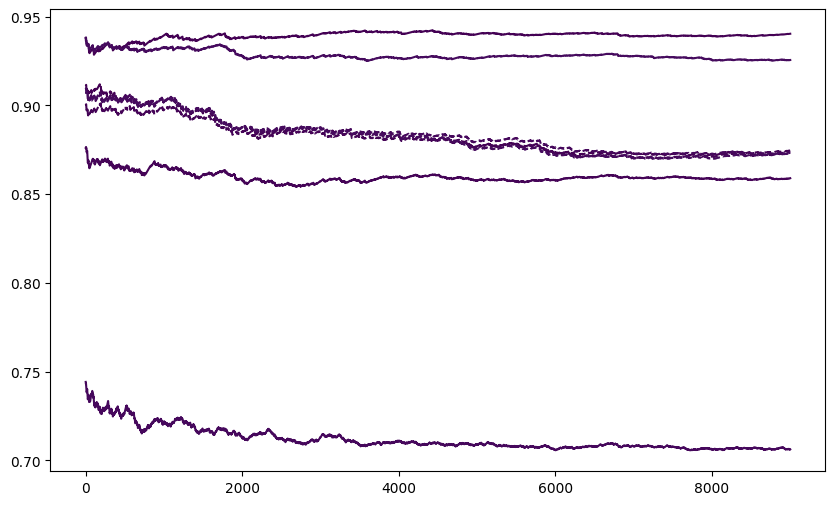

In [32]:
from matplotlib import cm

# Convert lists to numpy arrays
posterior_pds = np.array(posterior_pds)
logBR_prior_pds = np.array(logBR_prior_pds)
likelihood_prior_pds = np.array(likelihood_prior_pds)

# Compute biases for all points on the circle
bias_for = []
bias_for_ml = []
burn = 1000

for idx in range(0, 4):#num_points):
    logBR_prior_pd_values = idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel()
    likelihood_prior_pd_values = idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel()

    bias_for_values = logBR_prior_pd_values > 0
    bias_for_mci = bias_for_values.cumsum() / np.arange(1, len(bias_for_values) + 1)

    mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
    y_samples = idata.posterior[f'y_l_{idx}'].values
    marginal_likelihoods = normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2)
    log_marginal_likelihoods = np.log(np.exp(marginal_likelihoods).mean(axis=-1)).ravel()

    bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods) >= 0
    bias_for_ml_mci = bias_for_ml_values.cumsum() / np.arange(1, len(bias_for_ml_values) + 1)

    bias_for.append(bias_for_mci)
    bias_for_ml.append(bias_for_ml_mci)

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx][burn:], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx][burn:], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis: bias for n={}".format(n))
plt.show()

In [28]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Define prior parameters
mu_prior_mean = 0
mu_prior_sigma = 1

sigma_prior_mu = 1
sigma_prior_sigma = 1

n = 20  # Number of observations
p = 2  # Number of covariates

# Design matrix X
X = np.random.normal(size=(n, p))

# Ground truth parameters for generating data
beta0 = np.array([1, 2])
mu0 = np.dot(X, beta0)
delta = 0.05
sigma0 = 1

# Generate points on the circle
num_points = 100  # Number of points on the circle
theta = np.linspace(0, 2 * np.pi, num_points)
circle_points = np.column_stack((beta0[0] + delta * np.cos(theta), beta0[1] + delta * np.sin(theta)))

# Precompute some matrices
X_transpose = X.T
Sigma_inv = np.eye(n) / sigma0**2
Sigma_beta_inv = np.eye(p) / mu_prior_sigma**2

# Precompute posterior mean and covariance for beta for all points
cov_beta_post = np.linalg.inv(np.dot(X_transpose, np.dot(Sigma_inv, X)) + Sigma_beta_inv)
mean_beta_post_all = np.dot(cov_beta_post, np.dot(X_transpose, Sigma_inv.dot(X.dot(circle_points.T))) + Sigma_beta_inv.dot(np.ones((p, num_points)) * mu_prior_mean))

with pm.Model() as model:
    # Priors
    beta = pm.Normal('beta', mu=mu_prior_mean, sigma=mu_prior_sigma, shape=(p,))
    sigma = pm.TruncatedNormal("sigma", mu=sigma_prior_mu, sigma=sigma_prior_sigma, lower=0)

    mu = pm.Deterministic("mu", pm.math.dot(X, beta))

    # Generate response variable y for each point on the circle
    yl_all = mu0[:, None] + np.random.normal(0, sigma0, (n, num_points))

    # Likelihood for all points
    y_l = pm.MvNormal('y_l', mu=np.tile(mu0[:, None], num_points), cov=(sigma0**2) * np.eye(n), shape=(n, num_points))

    # Posterior log-probability for all points
    posterior_betal_all = pm.MvNormal('posterior_betal', mu=mean_beta_post_all.T, cov=cov_beta_post, shape=(num_points, p))
    posterior_pdl_all = pm.Deterministic('posterior_pdl', pm.logp(pm.MvNormal.dist(mu=pm.math.dot(X, posterior_betal_all.T), cov=(sigma0**2) * np.eye(n)), mu0[:, None]).sum(axis=0))

    # Log BR for all points
    logBR_prior_pdl_all = pm.Deterministic('logBR_prior_pdl', posterior_pdl_all - pm.logp(pm.MvNormal.dist(mu=mu_prior_mean, cov=(mu_prior_sigma**2) * np.eye(n)), pm.math.dot(X, beta)).sum())

    # Likelihood for all points
    likelihood_prior_pdl_all = pm.Deterministic('likelihood_prior_pdl', pm.logp(pm.MvNormal.dist(mu=mu0[:, None], cov=(sigma**2) * np.eye(n)), y_l).sum(axis=0))

    # Sampling
    idata = pm.sample(draws=5000, tune=1000)

# Use ArviZ to analyze the results
az.summary(idata)
az.plot_trace(idata)
plt.show()
print(idata.posterior)



ValueError: Incompatible Elemwise input shapes [(1, 20), (20, 100)]

In [ ]:
from matplotlib import cm
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
posterior_pds = np.array(posterior_pds)
logBR_prior_pds = np.array(logBR_prior_pds)
likelihood_prior_pds = np.array(likelihood_prior_pds)

# Define the number of points
num_points = 100

# Initialize arrays for biases
burn = 1000
bias_for = np.zeros((num_points, 5000 - burn))
bias_for_ml = np.zeros((num_points, 5000 - burn))

# Compute logBR_prior_pd_values and likelihood_prior_pd_values for all points on the circle
logBR_prior_pd_values = np.array([idata.posterior[f'logBR_prior_pdl_{idx}'].values.ravel() for idx in range(num_points)])
likelihood_prior_pd_values = np.array([idata.posterior[f'likelihood_prior_pdl_{idx}'].values.ravel() for idx in range(num_points)])

# Compute bias_for_values for all points
bias_for_values = logBR_prior_pd_values > 0
bias_for_cumsum = bias_for_values.cumsum(axis=1)
bias_for_mci = bias_for_cumsum / np.arange(1, bias_for_values.shape[1] + 1)

# Sample mu_samples and compute y_samples for all points
mu_samples = idata.posterior['mu'][:, :, 0].values.ravel()[:1000]
y_samples = np.array([idata.posterior[f'y_l_{idx}'].values for idx in range(num_points)])

# Compute marginal_likelihoods and log_marginal_likelihoods
marginal_likelihoods = np.exp(normal_logp_np(y_samples[:, :, :, np.newaxis], mu_samples, 1).sum(axis=2))
log_marginal_likelihoods = np.log(marginal_likelihoods.mean(axis=-1)).ravel()

# Compute bias_for_ml_values for all points
bias_for_ml_values = (likelihood_prior_pd_values - log_marginal_likelihoods[:, np.newaxis]) >= 0
bias_for_ml_cumsum = bias_for_ml_values.cumsum(axis=1)
bias_for_ml_mci = bias_for_ml_cumsum / np.arange(1, bias_for_ml_values.shape[1] + 1)

# Assign the computed values to the bias_for and bias_for_ml arrays
bias_for[:, :] = bias_for_mci[:, burn:]
bias_for_ml[:, :] = bias_for_ml_mci[:, burn:]

# Generate colors from a colormap
colors = cm.viridis(np.linspace(0, 1, num_points))

# Plotting the color gradient
plt.figure(figsize=(10, 1))
for idx, color in enumerate(colors):
    plt.plot([idx, idx], [0, 1], color=color, linewidth=8)
plt.title("Color Gradient")
plt.yticks([])
plt.show()

# Plotting
plt.figure(figsize=(10, 6))
for idx in range(num_points):
    plt.plot(bias_for[idx], label=f'Bias For (Analytical) Point {idx}', color=colors[idx])
    plt.plot(bias_for_ml[idx], label=f'Bias For (Simulation) Point {idx}', linestyle='--', color=colors[idx])

plt.title("Hypothesis: bias for n={}".format(n))
plt.show()


Rhombus

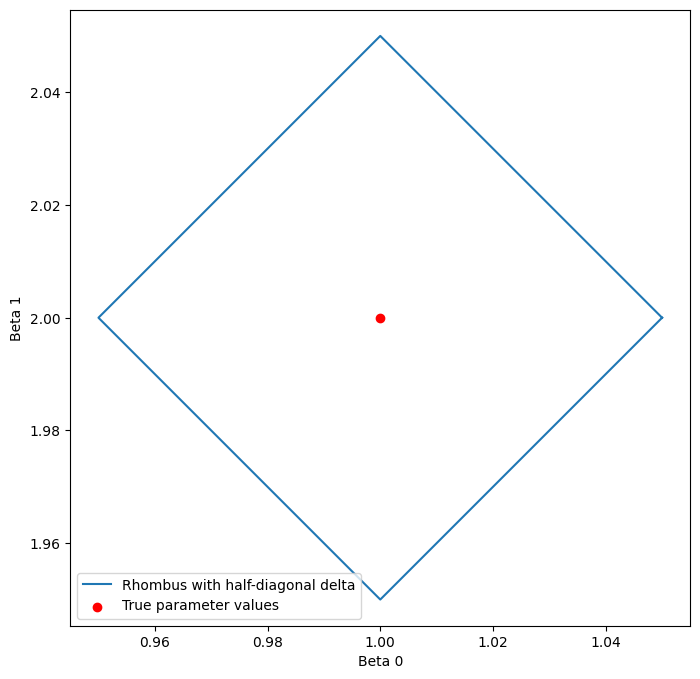

[[1.05       2.        ]
 [1.04791667 2.00208333]
 [1.04583333 2.00416667]
 [1.04375    2.00625   ]
 [1.04166667 2.00833333]
 [1.03958333 2.01041667]
 [1.0375     2.0125    ]
 [1.03541667 2.01458333]
 [1.03333333 2.01666667]
 [1.03125    2.01875   ]
 [1.02916667 2.02083333]
 [1.02708333 2.02291667]
 [1.025      2.025     ]
 [1.02291667 2.02708333]
 [1.02083333 2.02916667]
 [1.01875    2.03125   ]
 [1.01666667 2.03333333]
 [1.01458333 2.03541667]
 [1.0125     2.0375    ]
 [1.01041667 2.03958333]
 [1.00833333 2.04166667]
 [1.00625    2.04375   ]
 [1.00416667 2.04583333]
 [1.00208333 2.04791667]
 [1.         2.05      ]
 [1.         2.05      ]
 [0.99791667 2.04791667]
 [0.99583333 2.04583333]
 [0.99375    2.04375   ]
 [0.99166667 2.04166667]
 [0.98958333 2.03958333]
 [0.9875     2.0375    ]
 [0.98541667 2.03541667]
 [0.98333333 2.03333333]
 [0.98125    2.03125   ]
 [0.97916667 2.02916667]
 [0.97708333 2.02708333]
 [0.975      2.025     ]
 [0.97291667 2.02291667]
 [0.97083333 2.02083333]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# True parameter values
beta0 = np.array([1, 2])
delta = 0.05  # Half-diagonal length of the rhombus

# Generate points on the rhombus
num_points_per_side = 25  # Number of points on each side of the rhombus

# Define the four vertices of the rhombus
vertices = np.array([
    [beta0[0] + delta, beta0[1]],  # Right vertex
    [beta0[0], beta0[1] + delta],  # Top vertex
    [beta0[0] - delta, beta0[1]],  # Left vertex
    [beta0[0], beta0[1] - delta]   # Bottom vertex
])

# Generate points along each side of the rhombus
points = []
for i in range(4):
    start = vertices[i]
    end = vertices[(i + 1) % 4]
    side_points = np.linspace(start, end, num_points_per_side)
    points.append(side_points)

# Concatenate all points
rhombus_points = np.vstack(points)

# Plotting the rhombus and the true parameter values
plt.figure(figsize=(8, 8))
plt.plot(rhombus_points[:, 0], rhombus_points[:, 1], label='Rhombus with half-diagonal delta')
plt.scatter(beta0[0], beta0[1], color='red', label='True parameter values')
plt.xlabel('Beta 0')
plt.ylabel('Beta 1')
plt.legend(loc=3)
plt.axis('equal')
plt.show()

# Print the points on the rhombus
